## Programming Assignment 5
#### In this assignment, you will be implementing Tomasi-Kanade	Factorization algorithm	for Rigid Structure from Motion.

### Task 1
#### Load the data file and generate a 2D image dataset	by generating an orthographic camera with optical axis paralle to the XY plane, which rotates around the teapot	in 10° increments and always looks towards the center of the object
#### Note: Code for loading the point cloud and visualizing it has been given to you. Further build on it and take images of the teapot and visualize them

In [2]:
from scipy.io import loadmat
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


x = loadmat('teapot.mat')

a = []
b = []
c = []
for points in x['verts']:
    a.append(points[0])
    b.append(points[1])
    c.append(points[2])
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,c, c='g', marker='*')

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


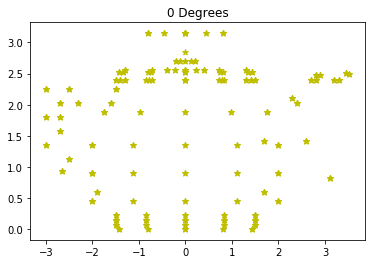

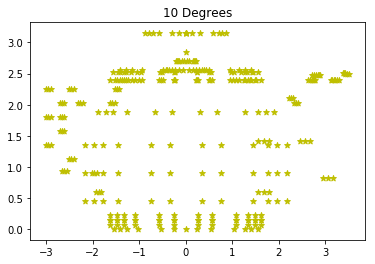

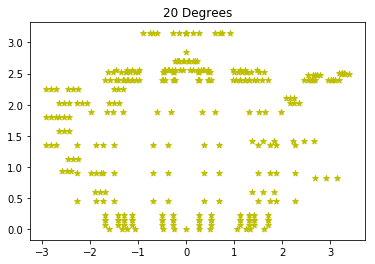

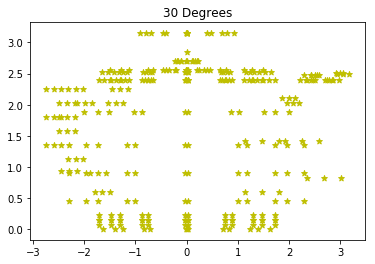

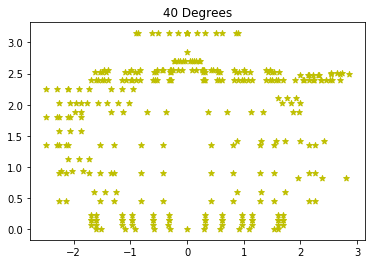

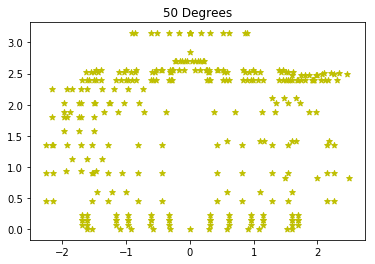

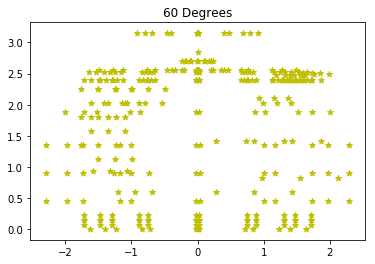

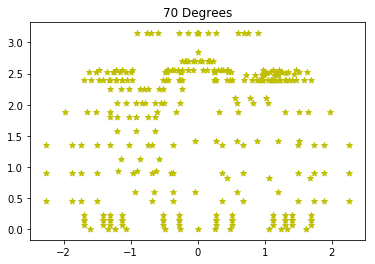

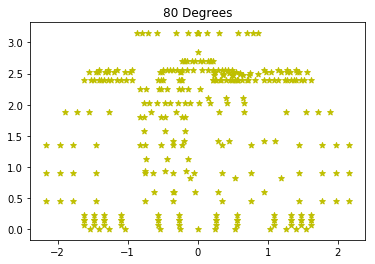

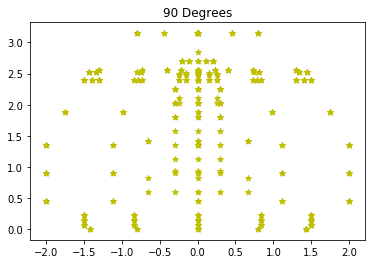

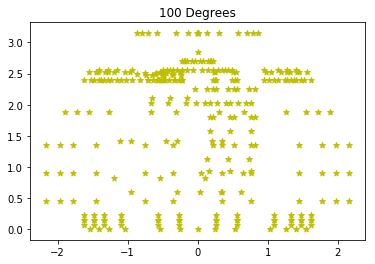

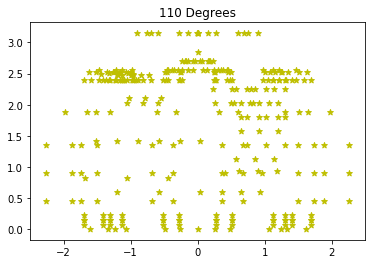

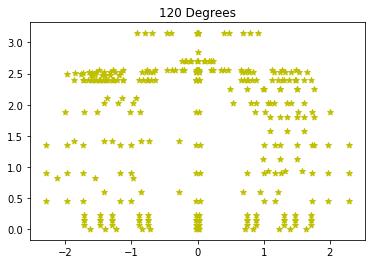

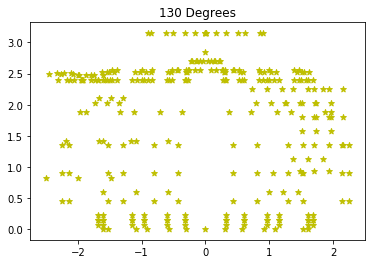

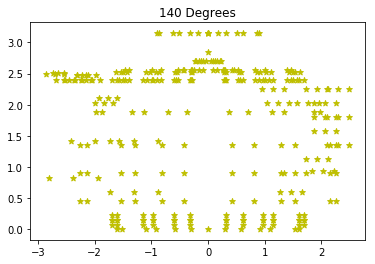

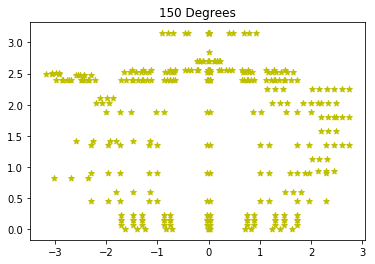

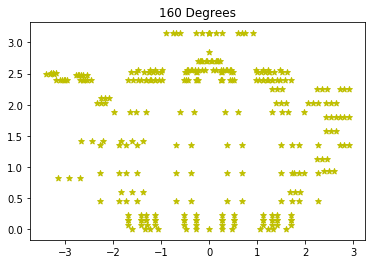

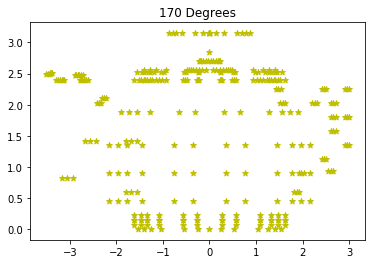

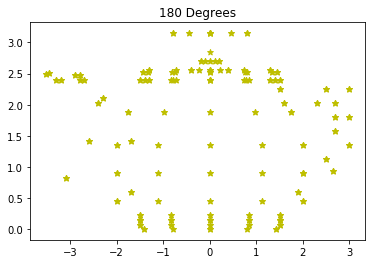

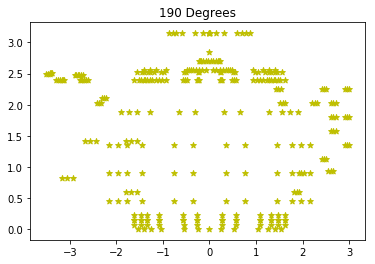

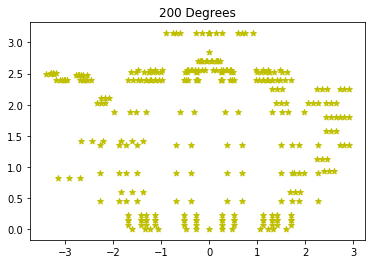

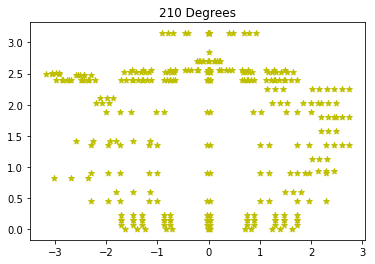

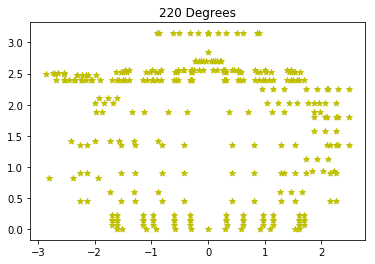

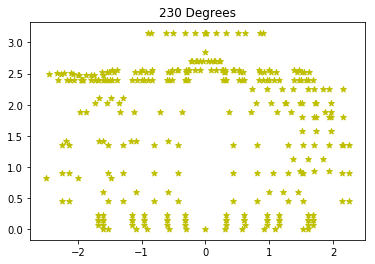

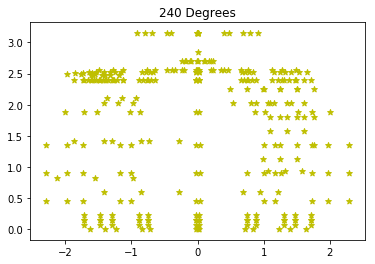

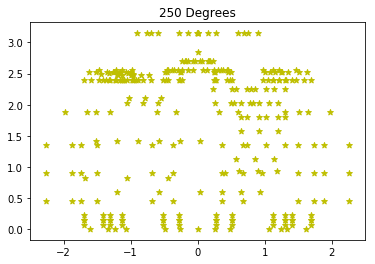

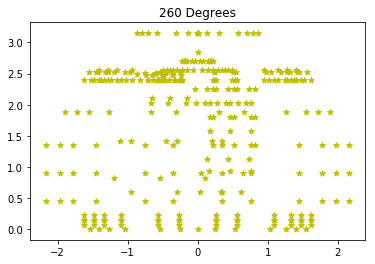

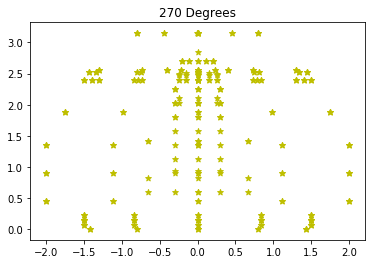

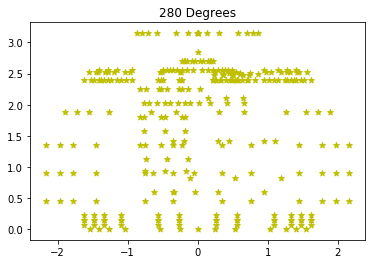

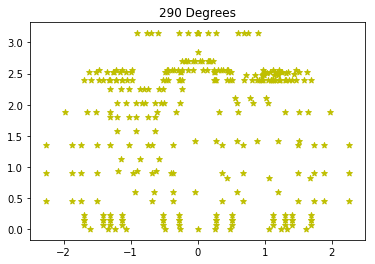

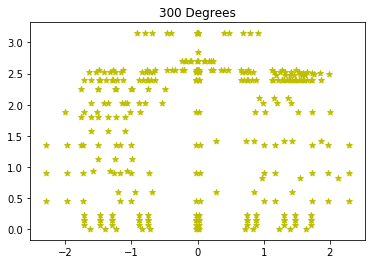

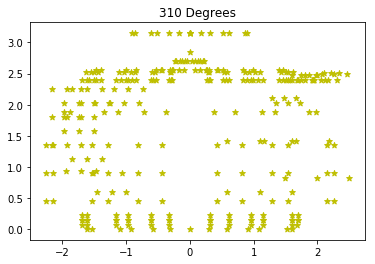

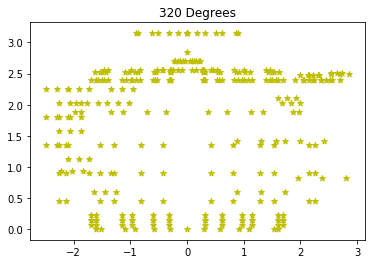

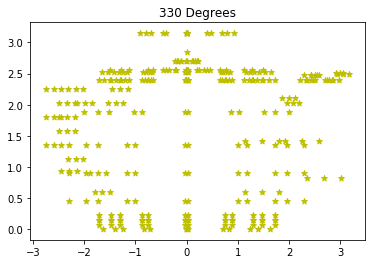

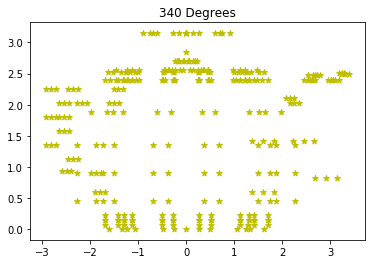

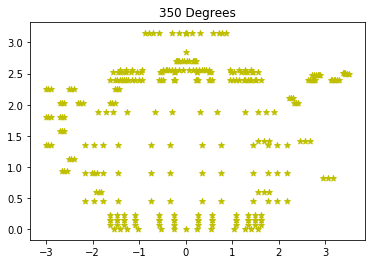

In [3]:
homo = np.ones((len(a)))
pts = np.array([a,b,c,homo])
theeta= 10
K = np.array([[1,0,0],[0,0,1]])
W = np.zeros((72,306))

degree = 0
c = 0

def reconstruct2D(degree, pts, K, W):
    global c
    R = np.array([[np.cos(np.radians(degree)), -(np.sin(np.radians(degree))),0, 0],
                  [np.sin(np.radians(degree)), np.cos(np.radians(degree)), 0, 0],
                  [0,      0,    1, 0]])
    
    img = np.matmul(K,np.matmul(R,pts))
                             
    fig = plt.figure()
    fx = fig.add_subplot(111)
    fx.scatter(img[0],img[1], c='y', marker='*')
    fx.set_title(str(degree) + " Degrees")
    W[c] = img[0]
    W[c+1] = img[1]
    c+=2
    
    return
  

for i in range(36):
    reconstruct2D(degree,pts, K, W)
    degree = degree + theeta


In [4]:
# W is the 2FxP matrix
# img is the matrix containing points
print(W)

[[1.4        1.4        0.784      ... 1.5        0.798      1.425     ]
 [2.4        2.4        2.4        ... 0.075      0.         0.        ]
 [1.37873085 1.51487103 1.01519673 ... 1.6230761  1.03332524 1.54192229]
 ...
 [2.4        2.4        2.4        ... 0.075      0.         0.        ]
 [1.37873085 1.24259068 0.52898183 ... 1.33134716 0.53842793 1.2647798 ]
 [2.4        2.4        2.4        ... 0.075      0.         0.        ]]


### Task 2
#### Use the data generated in previous task to generate a W matrix, and use that as input in Tomasi Kanade Factorization method to compute the 3D structure

In [6]:
U, S, Vt = np.linalg.svd(W);

R_hat = U[:,0:3]

V_hat = Vt[0:3,:]

S_hat = np.array([[S[0], S[1], S[2]],
                 [S[3], S[4], S[5]],
                 [S[6], S[7], S[8]]])

S_hat = np.matmul(S_hat, V_hat)
print(R_hat.shape,S_hat.shape,V_hat.shape)

def generateMatrix(R_hat):

    c = 0
    c2 = 0

    A= np.zeros((36*3, 6))
    B = np.zeros((3*36,1))

    for i in range(36):
        j=c;
        j2=c+1;
        r1 = R_hat[j][0]
        r2 = R_hat[j][1]
        r3 = R_hat[j][2]

        r4 = R_hat[j2][0]
        r5 = R_hat[j2][1]
        r6 = R_hat[j2][2]
        c+=2

        A[c2]   = [(r1*r1), (2*r1*r2), (2*r1*r3), (r1*r2), (2*r2*r3), (r3*r3)]
        A[c2+1] = [(r4*r4), (2*r4*r5), (2*r4*r6), (r5*r5), (2*r5*r6), (r6*r6)]
        A[c2+2] = [(r1*r4), (2*r1*r5), (2*r1*r6), (r2*r5), (2*r2*r6), (r6*r6)]
        B[c2]   = [1]
        B[c2+1] = [1]
        B[c2+2] = [0]

        c2+=3

    X = np.matmul(np.linalg.inv(np.matmul(A.T,A)),(np.matmul(A.T,B)))

    return X

X = generateMatrix(R_hat)
Q= np.zeros((3,3))
Q[0] = [X[0], X[1], X[2]]
Q[1] = [X[1], X[3], X[4]]
Q[2] = [X[2], X[4], X[5]]

Q_hat = np.linalg.cholesky(Q)
S = np.matmul(np.linalg.inv(Q_hat),S_hat)

R = np.matmul(R_hat, Q_hat)

W_new = np.matmul(R,S)
print(W_new)
print(W_new.shape)


(72, 3) (3, 306) (3, 306)
6


LinAlgError: Matrix is not positive definite

### Task 3
#### Use some error metric to determine the error between actual and calculated values

In [6]:
def errorFunc(A,B):
    err=0
    for i in range(36*2):
        x = (A[i]-B[i])**2
        err+=np.sum(x)
    return (err/306)
Error = errorFunc(W,W_new)
print("Error :", Error)

### Task 4 
#### Suggest a modification to this method or another existing alogirithm. Also explain the situations under which this algorithm might fail

#### Your answer comes here